In [1]:
# special functions for using pyradiomics
from SimpleITK import GetImageFromArray
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor 
import logging
logging.getLogger('radiomics').setLevel(logging.CRITICAL + 1)  

In [3]:
# Instantiate the extractor
texture_extractor = RadiomicsFeatureExtractor(verbose=False)
texture_extractor.disableAllFeatures()
_text_feat = {ckey: [] for ckey in texture_extractor.featureClassNames}
texture_extractor.enableFeaturesByName(**_text_feat)

print('Extraction parameters:\n\t', texture_extractor.settings)
print('Enabled filters:\n\t', texture_extractor.enabledImagetypes) 
print('Enabled features:\n\t', texture_extractor.enabledFeatures) 

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'verbose': False}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': [], 'shape2D': []}


In [4]:
import numpy as np 
import pandas as pd 
import h5py 
import skimage 
import sklearn 
import os 
from pathlib import Path 
import glob
import cv2

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

In [6]:
train_df=pd.read_csv('D:\dataset\late_blight\dataset.csv')
#train_df = pd.read_csv('../input/train.csv')
train_df.head(15) 

,scan_id,image_path
0,1000,Tometo_Late_blight_1000.jpg
1,1001,Tometo_Late_blight_1001.jpg
2,1002,Tometo_Late_blight_1002.jpg
3,1003,Tometo_Late_blight_1003.jpg
4,1004,Tometo_Late_blight_1004.jpg
5,1005,Tometo_Late_blight_1005.jpg
6,1006,Tometo_Late_blight_1006.jpg
7,1007,Tometo_Late_blight_1007.jpg
8,1008,Tometo_Late_blight_1008.jpg
9,1009,Tometo_Late_blight_1009.jpg


In [7]:
  def read_scan(in_filename, folder='late_blight'):
    full_scan_path = os.path.join('D:\dataset\late_blight', in_filename)
    data=str(full_scan_path)
    images=cv2.imread(data)
    return images

In [11]:
sample_scan = train_df.iloc[2] 
print(sample_scan)
image_data = read_scan(sample_scan['image_path'])
print('Image Shape:', image_data.shape)

scan_id                              1002
image_path    Tometo_Late_blight_1002.jpg
Name: 2, dtype: object
Image Shape: (256, 256, 3)


In [12]:
type(image_data)

numpy.ndarray

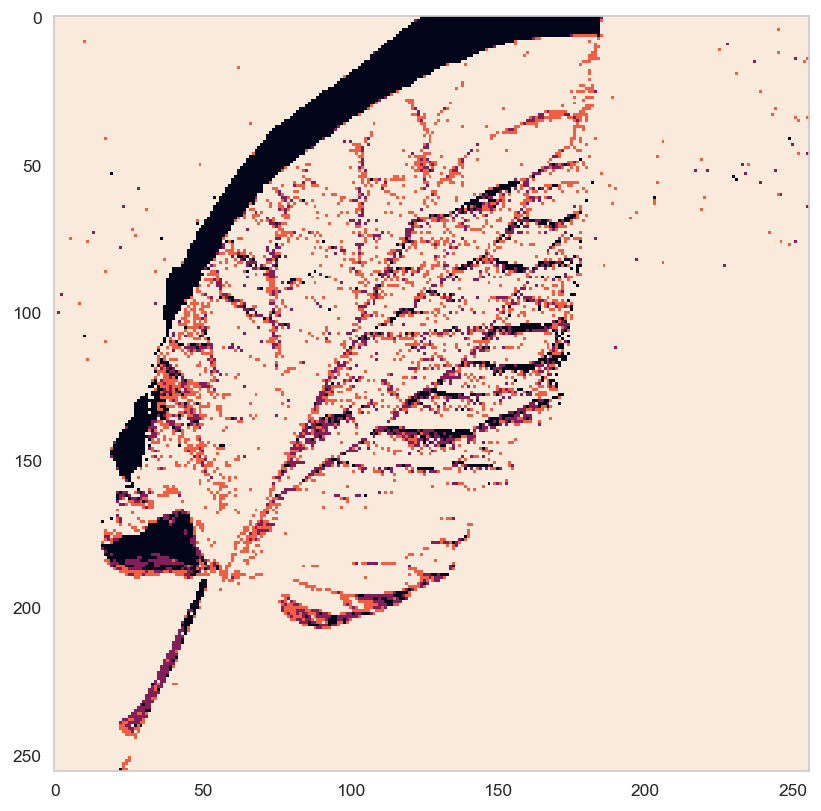

In [24]:

plt.imshow(np.sum((image_data>60).astype(float), -1))

In [25]:
%%time
results = texture_extractor.execute(GetImageFromArray(image_data),
                            GetImageFromArray((image_data>0).astype(np.uint8)))

Wall time: 1min 9s


In [26]:
pd.DataFrame([results]).T

,0
diagnostics_Versions_PyRadiomics,v3.0
diagnostics_Versions_Numpy,1.18.1
diagnostics_Versions_SimpleITK,1.2.4
diagnostics_Versions_PyWavelet,1.0.0
diagnostics_Versions_Python,3.7.6
...,...
original_ngtdm_Busyness,294.9374543531139
original_ngtdm_Coarseness,4.984418626155884e-05
original_ngtdm_Complexity,35.26752248180465
original_ngtdm_Contrast,0.04505094514383641


In [27]:
def calc_radiomics(in_image_data):
    return texture_extractor.execute(GetImageFromArray(in_image_data),
                            GetImageFromArray((in_image_data>0).astype(np.uint8)))

In [28]:
%%time
train_df['radiomics'] = train_df['image_path'].map(lambda c_filename: calc_radiomics(read_scan(c_filename)))

Wall time: 10min 2s


In [29]:
new_train_df = pd.DataFrame([dict(**c_row.pop('radiomics'), **c_row) for _, c_row in train_df.iterrows()])
New_train_df = pd.DataFrame(np.array([new_train_df['original_shape_Elongation'],new_train_df['original_shape_Flatness'],new_train_df['original_shape_LeastAxisLength'],new_train_df['original_shape_MajorAxisLength'],new_train_df['original_shape_Maximum2DDiameterColumn'],new_train_df['original_shape_Maximum2DDiameterRow'],new_train_df['original_shape_Maximum2DDiameterSlice'],new_train_df['original_shape_Maximum3DDiameter'],new_train_df['original_shape_MeshVolume'],new_train_df['original_shape_MinorAxisLength'],new_train_df['original_shape_Sphericity'],new_train_df['original_shape_SurfaceArea'],new_train_df['original_shape_SurfaceVolumeRatio'],new_train_df['original_shape_VoxelVolume'],new_train_df['original_firstorder_10Percentile'],new_train_df['original_firstorder_90Percentile'],new_train_df['original_firstorder_Energy'],new_train_df['original_firstorder_Entropy'],new_train_df['original_firstorder_InterquartileRange'],new_train_df['original_firstorder_Kurtosis'],new_train_df['original_firstorder_Maximum'],new_train_df['original_firstorder_MeanAbsoluteDeviation'],new_train_df['original_firstorder_Mean'],new_train_df['original_firstorder_Median'],new_train_df['original_firstorder_Minimum'],new_train_df['original_firstorder_Range'],new_train_df['original_firstorder_RobustMeanAbsoluteDeviation'],new_train_df['original_firstorder_RootMeanSquared'],new_train_df['original_firstorder_Skewness'],new_train_df['original_firstorder_TotalEnergy'],new_train_df['original_firstorder_Uniformity'],new_train_df['original_firstorder_Variance'],new_train_df['original_glcm_Autocorrelation'],new_train_df['original_glcm_ClusterProminence'],new_train_df['original_glcm_ClusterShade'],new_train_df['original_glcm_ClusterTendency'],new_train_df['original_glcm_Contrast'],new_train_df['original_glcm_Correlation'],new_train_df['original_glcm_DifferenceAverage'],new_train_df['original_glcm_DifferenceEntropy'],new_train_df['original_glcm_DifferenceVariance'],new_train_df['original_glcm_Id'],new_train_df['original_glcm_Idm'],new_train_df['original_glcm_Idmn'],new_train_df['original_glcm_Idn'],new_train_df['original_glcm_Imc1'],new_train_df['original_glcm_Imc2'],new_train_df['original_glcm_InverseVariance'],new_train_df['original_glcm_JointAverage'],new_train_df['original_glcm_JointEnergy'],new_train_df['original_glcm_JointEntropy'],new_train_df['original_glcm_MCC'],new_train_df['original_glcm_MaximumProbability'],new_train_df['original_glcm_SumAverage'],new_train_df['original_glcm_SumEntropy'],new_train_df['original_glcm_SumSquares'],new_train_df['original_gldm_DependenceEntropy'],new_train_df['original_gldm_DependenceNonUniformity'],new_train_df['original_gldm_DependenceNonUniformityNormalized'],new_train_df['original_gldm_DependenceVariance'],new_train_df['original_gldm_GrayLevelNonUniformity'],new_train_df['original_gldm_GrayLevelVariance'],new_train_df['original_gldm_HighGrayLevelEmphasis'],new_train_df['original_gldm_LargeDependenceEmphasis'],new_train_df['original_gldm_LargeDependenceHighGrayLevelEmphasis'],new_train_df['original_gldm_LargeDependenceLowGrayLevelEmphasis'],new_train_df['original_gldm_LowGrayLevelEmphasis'],new_train_df['original_gldm_SmallDependenceEmphasis'],new_train_df['original_gldm_SmallDependenceHighGrayLevelEmphasis'],new_train_df['original_gldm_SmallDependenceLowGrayLevelEmphasis'],new_train_df['original_glrlm_GrayLevelNonUniformity'],new_train_df['original_glrlm_GrayLevelNonUniformityNormalized'],new_train_df['original_glrlm_GrayLevelVariance'],new_train_df['original_glrlm_HighGrayLevelRunEmphasis'],new_train_df['original_glrlm_LongRunEmphasis'],new_train_df['original_glrlm_LongRunHighGrayLevelEmphasis'],new_train_df['original_glrlm_LongRunLowGrayLevelEmphasis'],new_train_df['original_glrlm_LowGrayLevelRunEmphasis'],new_train_df['original_glrlm_RunEntropy'],new_train_df['original_glrlm_RunLengthNonUniformity'],new_train_df['original_glrlm_RunLengthNonUniformityNormalized'],new_train_df['original_glrlm_RunPercentage'],new_train_df['original_glrlm_RunVariance'],new_train_df['original_glrlm_ShortRunEmphasis'],new_train_df['original_glrlm_ShortRunHighGrayLevelEmphasis'],new_train_df['original_glrlm_ShortRunLowGrayLevelEmphasis'],new_train_df['original_glszm_GrayLevelNonUniformity'],new_train_df['original_glszm_GrayLevelNonUniformityNormalized'],new_train_df['original_glszm_GrayLevelVariance'],new_train_df['original_glszm_HighGrayLevelZoneEmphasis'],new_train_df['original_glszm_LargeAreaEmphasis'],new_train_df['original_glszm_LargeAreaHighGrayLevelEmphasis'],new_train_df['original_glszm_LargeAreaLowGrayLevelEmphasis'],new_train_df['original_glszm_LowGrayLevelZoneEmphasis'],new_train_df['original_glszm_SizeZoneNonUniformity'],new_train_df['original_glszm_SizeZoneNonUniformityNormalized'],new_train_df['original_glszm_SmallAreaEmphasis'],new_train_df['original_glszm_SmallAreaHighGrayLevelEmphasis'],new_train_df['original_glszm_SmallAreaLowGrayLevelEmphasis'],new_train_df['original_glszm_ZoneEntropy'],new_train_df['original_glszm_ZonePercentage'],new_train_df['original_glszm_ZoneVariance'],new_train_df['original_ngtdm_Busyness'],new_train_df['original_ngtdm_Coarseness'],new_train_df['original_ngtdm_Complexity'],new_train_df['original_ngtdm_Contrast'],new_train_df['original_ngtdm_Strength']])).T
New_train_df.insert(0,"scan_id",train_df['scan_id'])
New_train_df.insert(1,"image_path",train_df['image_path'])
numpyheader =np.array(['scan_id','image_path','original_shape_Elongation','original_shape_Flatness','original_shape_LeastAxisLength','original_shape_MajorAxisLength','original_shape_Maximum2DDiameterColumn','original_shape_Maximum2DDiameterRow','original_shape_Maximum2DDiameterSlice','original_shape_Maximum3DDiameter','original_shape_MeshVolume','original_shape_MinorAxisLength','original_shape_Sphericity','original_shape_SurfaceArea','original_shape_SurfaceVolumeRatio','original_shape_VoxelVolume','original_firstorder_10Percentile','original_firstorder_90Percentile','original_firstorder_Energy','original_firstorder_Entropy','original_firstorder_InterquartileRange','original_firstorder_Kurtosis','original_firstorder_Maximum','original_firstorder_MeanAbsoluteDeviation','original_firstorder_Mean','original_firstorder_Median','original_firstorder_Minimum','original_firstorder_Range','original_firstorder_RobustMeanAbsoluteDeviation','original_firstorder_RootMeanSquared','original_firstorder_Skewness','original_firstorder_TotalEnergy','original_firstorder_Uniformity','original_firstorder_Variance','original_glcm_Autocorrelation','original_glcm_ClusterProminence','original_glcm_ClusterShade','original_glcm_ClusterTendency','original_glcm_Contrast','original_glcm_Correlation','original_glcm_DifferenceAverage','original_glcm_DifferenceEntropy','original_glcm_DifferenceVariance','original_glcm_Id','original_glcm_Idm','original_glcm_Idmn','original_glcm_Idn','original_glcm_Imc1','original_glcm_Imc2','original_glcm_InverseVariance','original_glcm_JointAverage','original_glcm_JointEnergy','original_glcm_JointEntropy','original_glcm_MCC','original_glcm_MaximumProbability','original_glcm_SumAverage','original_glcm_SumEntropy','original_glcm_SumSquares','original_gldm_DependenceEntropy','original_gldm_DependenceNonUniformity','original_gldm_DependenceNonUniformityNormalized','original_gldm_DependenceVariance','original_gldm_GrayLevelNonUniformity','original_gldm_GrayLevelVariance','original_gldm_HighGrayLevelEmphasis','original_gldm_LargeDependenceEmphasis','original_gldm_LargeDependenceHighGrayLevelEmphasis','original_gldm_LargeDependenceLowGrayLevelEmphasis','original_gldm_LowGrayLevelEmphasis','original_gldm_SmallDependenceEmphasis','original_gldm_SmallDependenceHighGrayLevelEmphasis','original_gldm_SmallDependenceLowGrayLevelEmphasis','original_glrlm_GrayLevelNonUniformity','original_glrlm_GrayLevelNonUniformityNormalized','original_glrlm_GrayLevelVariance','original_glrlm_HighGrayLevelRunEmphasis','original_glrlm_LongRunEmphasis','original_glrlm_LongRunHighGrayLevelEmphasis','original_glrlm_LongRunLowGrayLevelEmphasis','original_glrlm_LowGrayLevelRunEmphasis','original_glrlm_RunEntropy','original_glrlm_RunLengthNonUniformity','original_glrlm_RunLengthNonUniformityNormalized','original_glrlm_RunPercentage','original_glrlm_RunVariance','original_glrlm_ShortRunEmphasis','original_glrlm_ShortRunHighGrayLevelEmphasis','original_glrlm_ShortRunLowGrayLevelEmphasis','original_glszm_GrayLevelNonUniformity','original_glszm_GrayLevelNonUniformityNormalized','original_glszm_GrayLevelVariance','original_glszm_HighGrayLevelZoneEmphasis','original_glszm_LargeAreaEmphasis','original_glszm_LargeAreaHighGrayLevelEmphasis','original_glszm_LargeAreaLowGrayLevelEmphasis','original_glszm_LowGrayLevelZoneEmphasis','original_glszm_SizeZoneNonUniformity','original_glszm_SizeZoneNonUniformityNormalized','original_glszm_SmallAreaEmphasis','original_glszm_SmallAreaHighGrayLevelEmphasis','original_glszm_SmallAreaLowGrayLevelEmphasis','original_glszm_ZoneEntropy','original_glszm_ZonePercentage','original_glszm_ZoneVariance','original_ngtdm_Busyness','original_ngtdm_Coarseness','original_ngtdm_Complexity','original_ngtdm_Contrast','original_ngtdm_Strength'])

pd.DataFrame(New_train_df).to_csv("D:\dataset\late_blight\datasetfeature.csv",index=False,header=numpyheader)



In [30]:
df = pd.read_csv("D:\dataset\late_blight\datasetfeature.csv")
df.head(15)

,scan_id,image_path,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1000,Tometo_Late_blight_1000.jpg,0.998881,0.011017,3.261965,296.090977,256.007812,361.332257,256.007812,361.337792,...,15.087164,0.122625,5.479584,0.036544,3.978789e+05,311.623580,0.000063,34.334406,0.050563,0.002900
1,1001,Tometo_Late_blight_1001.jpg,0.999993,0.011049,3.265978,295.602586,256.007812,361.332257,256.007812,361.337792,...,17.613529,0.025968,5.293576,0.017960,4.422829e+06,243.508666,0.000047,16.929840,0.005537,0.002457
2,1002,Tometo_Late_blight_1002.jpg,0.999925,0.011038,3.264223,295.728569,256.007812,361.332257,256.007812,361.337792,...,21.910499,0.063557,5.534191,0.054125,2.792819e+05,294.937454,0.000050,35.267522,0.045051,0.002130
3,1003,Tometo_Late_blight_1003.jpg,0.999979,0.011047,3.265857,295.622799,256.007812,361.332257,256.007812,361.337792,...,12.952656,0.036049,5.694975,0.013974,3.751813e+06,270.022915,0.000050,16.530573,0.006530,0.002564
4,1004,Tometo_Late_blight_1004.jpg,0.999820,0.011042,3.265139,295.700885,256.007812,361.332257,256.007812,361.337792,...,16.896220,0.076984,6.043620,0.024354,7.596326e+05,221.217412,0.000055,31.850479,0.043554,0.002430
5,1005,Tometo_Late_blight_1005.jpg,0.999956,0.011046,3.265766,295.642525,256.007812,361.332257,256.007812,361.337792,...,11.544660,0.045962,5.923499,0.009916,4.940446e+06,199.992687,0.000069,14.510791,0.008999,0.002991
6,1006,Tometo_Late_blight_1006.jpg,0.998505,0.011013,3.261519,296.164701,256.007812,361.332257,256.007812,361.337792,...,21.427836,0.053356,6.035196,0.050060,1.816162e+05,277.166233,0.000052,36.172144,0.060086,0.002215
7,1007,Tometo_Late_blight_1007.jpg,0.999891,0.011045,3.265603,295.673561,256.007812,361.332257,256.007812,361.337792,...,14.803015,0.069760,5.878789,0.021915,9.851865e+05,254.674768,0.000070,20.981841,0.038515,0.002327
8,1008,Tometo_Late_blight_1008.jpg,0.999798,0.011044,3.265528,295.675244,256.007812,361.332257,256.007812,361.337792,...,25.400451,0.044969,5.904971,0.054620,4.294465e+05,236.298656,0.000046,35.834101,0.042690,0.002161
9,1009,Tometo_Late_blight_1009.jpg,0.999986,0.011048,3.265932,295.610468,256.007812,361.332257,256.007812,361.337792,...,14.277380,0.033195,5.742676,0.012544,3.883653e+06,250.530071,0.000062,13.165631,0.013038,0.002023


# Run Train and Test data

In [31]:
data = pd.read_csv('D:\dataset\late_blight\datasetfeature.csv')
X =(data.drop(['scan_id'],axis = 1))
y =(data['scan_id'])
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.2,shuffle=False)


In [36]:
X_train.to_csv('D:\\dataset\\late_blight\\new_train.csv', index=False)
X_train.head(12)

,image_path,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,Tometo_Late_blight_1000.jpg,0.998881,0.011017,3.261965,296.090977,256.007812,361.332257,256.007812,361.337792,195491.958333,...,15.087164,0.122625,5.479584,0.036544,3.978789e+05,311.623580,0.000063,34.334406,0.050563,0.002900
1,Tometo_Late_blight_1001.jpg,0.999993,0.011049,3.265978,295.602586,256.007812,361.332257,256.007812,361.337792,196349.500000,...,17.613529,0.025968,5.293576,0.017960,4.422829e+06,243.508666,0.000047,16.929840,0.005537,0.002457
2,Tometo_Late_blight_1002.jpg,0.999925,0.011038,3.264223,295.728569,256.007812,361.332257,256.007812,361.337792,195964.083333,...,21.910499,0.063557,5.534191,0.054125,2.792819e+05,294.937454,0.000050,35.267522,0.045051,0.002130
3,Tometo_Late_blight_1003.jpg,0.999979,0.011047,3.265857,295.622799,256.007812,361.332257,256.007812,361.337792,196324.833333,...,12.952656,0.036049,5.694975,0.013974,3.751813e+06,270.022915,0.000050,16.530573,0.006530,0.002564
4,Tometo_Late_blight_1004.jpg,0.999820,0.011042,3.265139,295.700885,256.007812,361.332257,256.007812,361.337792,196182.000000,...,16.896220,0.076984,6.043620,0.024354,7.596326e+05,221.217412,0.000055,31.850479,0.043554,0.002430
5,Tometo_Late_blight_1005.jpg,0.999956,0.011046,3.265766,295.642525,256.007812,361.332257,256.007812,361.337792,196300.500000,...,11.544660,0.045962,5.923499,0.009916,4.940446e+06,199.992687,0.000069,14.510791,0.008999,0.002991
6,Tometo_Late_blight_1006.jpg,0.998505,0.011013,3.261519,296.164701,256.007812,361.332257,256.007812,361.337792,195238.583333,...,21.427836,0.053356,6.035196,0.050060,1.816162e+05,277.166233,0.000052,36.172144,0.060086,0.002215
7,Tometo_Late_blight_1007.jpg,0.999891,0.011045,3.265603,295.673561,256.007812,361.332257,256.007812,361.337792,196260.583333,...,14.803015,0.069760,5.878789,0.021915,9.851865e+05,254.674768,0.000070,20.981841,0.038515,0.002327
8,Tometo_Late_blight_1008.jpg,0.999798,0.011044,3.265528,295.675244,256.007812,361.332257,256.007812,361.337792,196264.250000,...,25.400451,0.044969,5.904971,0.054620,4.294465e+05,236.298656,0.000046,35.834101,0.042690,0.002161
9,Tometo_Late_blight_1009.jpg,0.999986,0.011048,3.265932,295.610468,256.007812,361.332257,256.007812,361.337792,196340.833333,...,14.277380,0.033195,5.742676,0.012544,3.883653e+06,250.530071,0.000062,13.165631,0.013038,0.002023


In [37]:
X_test.to_csv('D:\\dataset\\late_blight\\new_test.csv', index=False)
X_test.head(3)

,image_path,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
12,Tometo_Late_blight_1012.jpg,0.997613,0.010984,3.256697,296.490786,256.007812,361.332257,256.007812,361.337792,194217.208333,...,21.209754,0.081898,5.941480,0.055752,1.096757e+05,359.167132,0.000053,41.840385,0.098990,0.002026
13,Tometo_Late_blight_1013.jpg,0.999731,0.011020,3.262502,296.053263,256.007812,361.332257,256.007812,361.337792,195496.333333,...,16.615253,0.083578,5.750165,0.025658,5.922947e+05,247.773745,0.000072,29.762751,0.059032,0.003483
14,Tometo_Late_blight_1014.jpg,0.999998,0.011049,3.265978,295.602586,256.007812,361.332257,256.007812,361.337792,196349.833333,...,17.647750,0.024812,5.210743,0.022359,2.232568e+06,254.016858,0.000051,18.650686,0.008871,0.002316
